# Homework Assignment

## Introduction

Goal of the homework assignment was to create insights from a sample database containing information about installs and transactions of the Shapr3d software. Moreover to replicate a key mertric, namely the `install_to_subscribe_ratio`.

Without further specification of this KPI, I have defined it as the ratio of application installs with transactions regardless of the transaction type. Meaning both trial and refunded transactions count as a valid subscription. More derivatives of this KPI can be developed that further elaborate this metric. For instance, the ratio of paid installs, ratio of monthly/yearly subscriptions, etc.


This notebook summarizes the findings as well as allows the reader to replicate the reesults.

## Summary of findings

- The overall install to subscribe ratio is 2.22% after the subscription service was launched in 2020-05-01.
- It fluctuates between 1.5% to 2.99% depending on the month and most probably the actual marketing campaigns and offers.
- Christmas period had the most installs but the conversion rate was the lowest. It can be the result of some focues marketing activity. This hypothesis needs to be validated further.
- The effect of marketing campaigns were also analyzed briefly. Users coming from Apple Ad network convert in higher rates than the organic users. The reason behind that could be that more relevant users are reached or the sign up process is easier there. To draw final conclusions, a further analysis needs to be performed.


## Assumptions infered from the data

- Each install is unique and no filtering needed to be applied.
- One user can have multiple installs and all of them counts in our `install_to_subscribe_ratio` metric.
- The transactions table contained unexplained records, namely duplicates were identifed where the `paid_at_date` equals the `expiration_date`. The root cause of this could not be identifed from the dataset. Therefore these records (86) were removed.


## Potential further steps to take

- Developing more, advanced, interactive visualizations to showcase the insights.
- Summary of findings in a presentation format. Following a top down approach: focusing first on the high level resutls firts, then break it down to the interesting details.
- Validation of the findings with deeper analysis of the data and with measuring statistical significance.
- Understanding the effect of the trial period, especially on the conversion rate.
- Regional breakdown of the user base and potential conversion differences.

In [56]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [57]:
import pandas as pd
from pysqlite3 import dbapi2 as sqlite3
from pathlib import Path
import sweetviz as sv
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

data_path = Path("../data")

installs = pd.read_csv(data_path.joinpath("shapr3d_ds_hw_installs.csv"), parse_dates=["date"])
transactions = pd.read_csv(data_path.joinpath("shapr3d_ds_hw_transaction.csv"), parse_dates=["paid_at_date"])


In [58]:
# Load the tables to a sqlite database
con = sqlite3.connect("homework.sqlite")

installs.to_sql("installs", con, if_exists="replace"), transactions.to_sql("transactions", con, if_exists="replace")

(267035, 43895)

### EDA 

Firts I ran some reports to get an understanding of the provided datasets.

The following remarks can be made from the installs:
- iOs is the dominant platform for the users.
- user_id is not unique, therefore the same user can use multiple devices.
- ~57% of the installs come from organic sources. While Google and Apple Ad networks contribute ~22-19% each. Meta platform is not used widely.


In [59]:
installs_report = sv.analyze(installs)
installs_report.show_html("../reports/installs.html")

                                             |          | [  0%]   00:00 -> (? left)

Report ../reports/installs.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


The following remarks can be made from the transactions:
- a user can have multiple transactions therefore if someone has a monthly subscription that will result in a record in each month
- 45% of the sampled transactions are coming from yearly subscriptions. Which is quite high but on the other hand it is heavily incentivized.
- It can also be the cause of the majority of the users have 1 transaction only since the observed timeframe is not that long. It needs to be validated further.

In [60]:
transactions_report = sv.analyze(transactions)
transactions_report.show_html("../reports/transactions.html")

                                             |          | [  0%]   00:00 -> (? left)

Report ../reports/transactions.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


<AxesSubplot:title={'center':'Number of users per transaction count'}, ylabel='Frequency'>

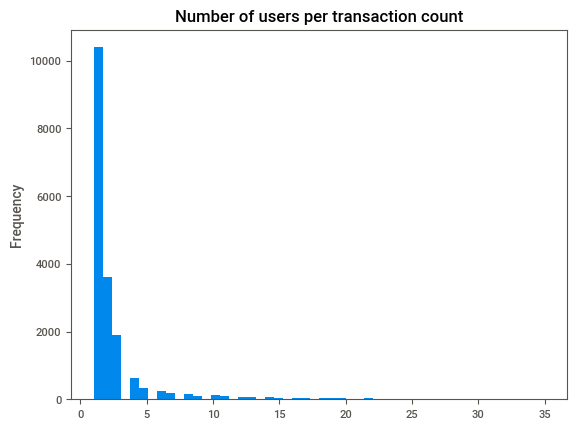

In [63]:
transactions.groupby("user_id").paid_at_date.count().sort_values(ascending=False).plot(kind="hist", bins=50, title="Number of users per transaction count")

### Install to subscribe ratio

Observations:
- The exact value of this metric in the complete sample is 2.2% which is around the industry average according to [CleverTap statistics](https://clevertap.com/blog/best-conversion-rate-for-mobile-app-downloads/)
- Paid subscriptions were only available from 2020-05-01. The value defined above already icorporates this insight.
- During Christmas period the install to subscribe ratio was the lowest but the subscribe rate was the highest. It could be the result of marketing activites or special discounts.

In [64]:
query = """

WITH users as (
    select
    i.device_id
    ,t.user_id
    ,i.date as install_date
    ,i.media_source
    ,i.channel
    ,i.platform
    ,i.country_code                                                                 as install_country
    ,t.paid_at_date
    ,t.trial
    ,t.is_refunded
    ,t.country_code                                                                 as transaction_country
    ,t.license
    ,t.subscription_period
    ,julianday(t.paid_at_date) - julianday(i.date)                                  as subs_datediff
    ,case when t.user_id is not null then 1 else 0 end                              as has_transaction
    ,row_number() over(partition by i.device_id, t.user_id, i.date 
                    order by julianday(t.paid_at_date) - julianday(i.date) asc)     as transaction_order
    
    from installs as i

    left join transactions as t
        on t.user_id = i.user_id
        and t.paid_at_date >= i.date
        and t.paid_at_date != expiration_date  -- filter out possible technical errors

)

select 
*
from users
where transaction_order = 1


"""

joined = pd.read_sql(query , con, parse_dates=["install_date", "paid_at_date"]).drop(columns=["transaction_order"])
joined['install_month'] = joined['install_date'].to_numpy().astype('datetime64[M]')

In [65]:
overall_ratio = joined.query("install_month >= '2020-05-01'")['has_transaction'].mean()
print("Install to subscribe ratio in the sample dataset: {0:.2f} %".format(overall_ratio*100, format=".2f"))

Install to subscribe ratio in the sample dataset: 2.22 %


In [66]:
joined.groupby("install_month").agg({"has_transaction": ["count", "sum", "mean"]}).droplevel(axis=1, level=0).reset_index().rename(columns={"count": "install_count", "sum": "transactions", "mean": "install_to_subscribe_ratio"})

,install_month,install_count,transactions,install_to_subscribe_ratio
0,2020-01-01,13541,0,0.000000
1,2020-02-01,11196,0,0.000000
2,2020-03-01,1837,0,0.000000
3,2020-04-01,1,0,0.000000
4,2020-05-01,12858,335,0.026054
5,2020-06-01,13153,318,0.024177
6,2020-07-01,12828,312,0.024322
7,2020-08-01,10803,324,0.029992
8,2020-09-01,11933,316,0.026481
9,2020-10-01,13138,283,0.021541


<AxesSubplot:title={'center':'Install count per month'}, xlabel='install_month'>

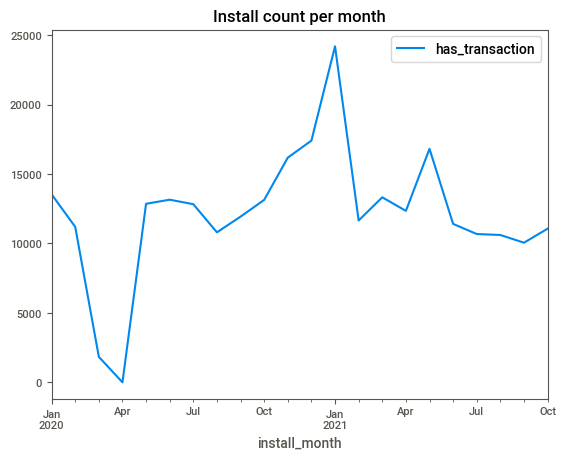

In [67]:
joined.groupby("install_month").agg({"has_transaction": "size"}).plot(title="Install count per month")

<AxesSubplot:title={'center':'Subscription ratio per month'}, xlabel='install_month'>

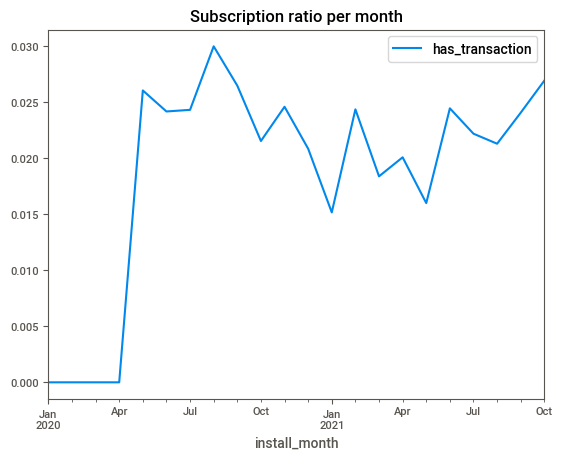

In [68]:
joined.groupby("install_month").agg({"has_transaction": "mean"}).plot(title="Subscription ratio per month")

### Effect of marketing campaigns

Multiple platform are used to lure users into the app. It is worth analyzing which of these platforms are the most effective.

Findings:
- Apple Search Ads has the highest conversion rate with 2.8% which is higher than the organic 2.3%.
- If the users paiy at least what is the cost of reaching them, then these campaigns are worth investing in.
- Interestingly, the Google Search Ads perform the poorest with 0.5%. The reason could be that the application was designed to work in the Apple ecosystem in the begining. 

The difference between the conversio rates was not yet tested for significance. The sample size is quite large. Validation can be done either a Chi-square test, Bayesian methods or simply by sampling the data a few thousand times.

In [69]:
joined.query("install_month >= '2020-05-01'").groupby("media_source").agg({"has_transaction": ["count", "sum", "mean"]}).sort_values(("has_transaction","mean"), ascending=False).droplevel(axis=1, level=0).reset_index().rename(columns={"count": "install_count", "sum": "transactions", "mean": "install_to_subscribe_ratio"})

,media_source,install_count,transactions,install_to_subscribe_ratio
0,google_lp,57,6,0.105263
1,confirmation,13,1,0.076923
2,website,454,23,0.050661
3,restricted,682,23,0.033724
4,None,713,22,0.030856
5,Apple Search Ads,45630,1291,0.028293
6,Social_facebook,210,5,0.023810
7,organic,134690,3178,0.023595
8,Website_rebranded,57,1,0.017544
9,Facebook Ads,4121,55,0.013346
